<a href="https://colab.research.google.com/github/utkarshminhas/violence-detection-fyp/blob/main/notebooks/jpg_to_tfds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import random
from glob import glob

In [2]:
processed_dir = '/content/drive/Shareddrives/Datasets/Raw RWF-2000 (without_mog)'
print(len(os.listdir(processed_dir)))
print(len(os.listdir(processed_dir+"/Fight")))
print(len(os.listdir(processed_dir+'/NonFight')))

2
1000
1000


In [4]:
image_size = (299, 299)

label_to_int = {
    # 'Fight': 0,
    # 'NonFight': 1
    'Fight': [1,0],
    'NonFight': [0,1]
}

fight=[1,0]
nonFight=[0,1]

In [5]:
def load_initial_data():
  labels=[]
  allImages=glob(os.path.join(processed_dir,"*/*/*.*"))
  for name in glob(os.path.join(processed_dir,"*/*/*.*")): 
      # print(name)
      if name.find('NonFight') != -1:
        labels.append(nonFight)
      else:
        labels.append(fight)
  return allImages,labels

In [6]:
imagePaths, labels =load_initial_data()

In [7]:
print(f"Images: {len(imagePaths)} - Labels: {len(labels)}",end="\n\n")

isFight = [i for i, x in enumerate(labels) if x == fight]

print("Fight Images ->",isFight[0],isFight[-1],len(isFight))
print(imagePaths[0])
print(imagePaths[29999],end="\n\n")

print("NonFight")
print(imagePaths[30000])
print(imagePaths[-1])

Images: 60000 - Labels: 60000

Fight Images -> 0 29999 30000
/content/drive/Shareddrives/Datasets/Raw RWF-2000 (without_mog)/Fight/Copy of mX4cQM1xMFc_2/frame_000.jpg
/content/drive/Shareddrives/Datasets/Raw RWF-2000 (without_mog)/Fight/Copy of RETYTDF_524/frame_029.jpg

NonFight
/content/drive/Shareddrives/Datasets/Raw RWF-2000 (without_mog)/NonFight/Copy of gNUhUpxZ_0/frame_000.jpg
/content/drive/Shareddrives/Datasets/Raw RWF-2000 (without_mog)/NonFight/Copy of r0mVR4J6_0/frame_029.jpg


In [9]:
def read_image(imagePath):
  img = cv2.imread(imagePath, cv2.IMREAD_COLOR) # Read in RGB  directly
  img = cv2.resize(img, image_size)
  img = img / 255.0
  img = img.astype(np.float32)
  return img

In [10]:
def preprocess(imagePath, label):
  def myFunction(imagePath):
    imagePath = imagePath.decode()
    image = read_image(imagePath)

    return image

  image= tf.numpy_function(myFunction, [imagePath], [tf.float32])[0]
  return image,label

In [11]:
def tf_dataset(imagePaths,labels,batch_size=30):
  dataset = tf.data.Dataset.from_tensor_slices((imagePaths, labels))
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
# %load_ext autotime

In [12]:
dataset = tf_dataset(imagePaths, labels)

One Batch is: (30, 299, 299, 3) (30, 2)
One image is: (299, 299, 3) (2,)

[1 0]


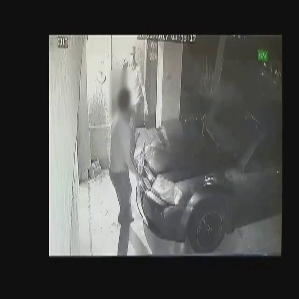

In [13]:
for x, y in dataset:
  x = x.numpy()
  y = y.numpy()
  print("One Batch is:",x.shape,y.shape)

  x = x[0] * 255
  y = y[0]
  print("One image is:",x.shape,y.shape,end="\n\n")
  
  print(y)
  cv2_imshow(x)
  break

In [16]:
def myGen():
  for x,y in dataset:
    yield x.numpy(),y.numpy()[0]

In [15]:
x,y=next(myGen())
print(x.shape,"  ",y.shape)
print(y)

(30, 299, 299, 3)    (2,)
[1 0]


In [17]:
ds = tf.data.Dataset.from_generator(myGen,output_signature = (tf.TensorSpec(shape=x.shape, dtype=tf.float32),tf.TensorSpec(shape=y.shape, dtype=tf.int32),))

In [18]:
batch_size=4 # creates a batch of 4 videos
ds=ds.batch(batch_size)

In [19]:
for x,y in ds:
  x=x.numpy()
  y=y.numpy()
  print(x.shape,y.shape)
  break

(4, 30, 299, 299, 3) (4, 2)


In [ ]:
# We can either use ds to fit the model
# or we can optimize the "dataset" above to give out the "batch_size" videos at once 